<a href="https://colab.research.google.com/github/AndrzejOlejniczak/Neural-Networks/blob/main/04_1_transfer_learning_feature_extraction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow
## Part 1: Feature Extraction

In [ ]:
#Are we using a GPU?
!nvidia-smi

Sun Jul 17 14:39:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Download the data

In [ ]:
# Get the data (10% of food101)
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-07-17 14:39:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.217.128, 173.194.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   208MB/s    in 0.8s    

2022-07-17 14:39:13 (208 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Unzip the file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

In [ ]:
# Check the dirs
import os

for dirpath, dirname, filename in os.walk('10_food_classes_10_percent'):
  print(f'{dirpath} {dirname} {len(filename)}')

10_food_classes_10_percent ['test', 'train'] 0
10_food_classes_10_percent/test ['hamburger', 'steak', 'ice_cream', 'chicken_curry', 'pizza', 'grilled_salmon', 'chicken_wings', 'fried_rice', 'ramen', 'sushi'] 0
10_food_classes_10_percent/test/hamburger [] 250
10_food_classes_10_percent/test/steak [] 250
10_food_classes_10_percent/test/ice_cream [] 250
10_food_classes_10_percent/test/chicken_curry [] 250
10_food_classes_10_percent/test/pizza [] 250
10_food_classes_10_percent/test/grilled_salmon [] 250
10_food_classes_10_percent/test/chicken_wings [] 250
10_food_classes_10_percent/test/fried_rice [] 250
10_food_classes_10_percent/test/ramen [] 250
10_food_classes_10_percent/test/sushi [] 250
10_food_classes_10_percent/train ['hamburger', 'steak', 'ice_cream', 'chicken_curry', 'pizza', 'grilled_salmon', 'chicken_wings', 'fried_rice', 'ramen', 'sushi'] 0
10_food_classes_10_percent/train/hamburger [] 75
10_food_classes_10_percent/train/steak [] 75
10_food_classes_10_percent/train/ice_cream [

### Create data loaders

In [ ]:
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

In [ ]:
# Import DataGenerators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setting ImageDataGenerator hyperparameters
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

# Setting data generators
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Setting flow from directory
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

test_data_10_percent = train_datagen.flow_from_directory(test_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode='categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### Setting up callbacks

In [ ]:
# Create tensorboard callback function
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  # Create log dir
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  
  # Create TensorBoard
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to {log_dir}')
  
  return tensorboard_callback

### Create model using TensorFlow Hub
https://tfhub.dev/google/efficientnet/b0/feature-vector/1 

In [ ]:
# Compare resnet and efficientnet models
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/google/efficientnet/b0/feature-vector/1'

In [ ]:
# Import dependencies 
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Create create_model() function 
def create_model(model_url, num_classes=10, input_shape=(224, 224, 3)):
  '''
  Takes a TensorFlow Hub URL and creates a Keras Sequential model
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL
    num_classes (int): Number of output neurons 
      should be equal to numbers of target classes, default 10
      input_shape (int tuple): input shape of the image

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  '''
  # Download the pretrained model and save it as keras layer:
  feature_extractor_layer = hub.KerasLayer(model_url, 
                                           trainable=False, 
                                           name='feature_extraction_layer',
                                           input_shape=input_shape)
  
  # Establish output layer activation function
  if num_classes == 1:
    activation = 'sigmoid'
  else:
    activation = 'softmax'
  
  # Create a Sequential model
  model = tf.keras.Sequential([feature_extractor_layer,
                               layers.Dense(num_classes, activation=activation, name='output_layer')
                               ])
  return model

### Create ResNet TensorFlow Hub Feature Extraction Model

In [ ]:
resnet_model = create_model(resnet_url)

In [ ]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# Compile resnet model
resnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Create TensorFlow Callback for the model
resnet_model_callback = create_tensorboard_callback('food101_transferL', 'resnet_001')

Saving TensorBoard log files to food101_transferL/resnet_001/20220717-100836


In [ ]:
# Fit the resnet model
resnet_history = resnet_model.fit(train_data_10_percent,
                 epochs=10,
                 callbacks=[resnet_model_callback],
                 validation_data=test_data_10_percent,
                 steps_per_epoch=len(train_data_10_percent),
                 validation_steps=len(test_data_10_percent))

Epoch 1/10
24/24 [==============================] - 18s 626ms/step - loss: 1.8782 - accuracy: 0.3853 - val_loss: 1.2057 - val_accuracy: 0.6176
Epoch 2/10
24/24 [==============================] - 14s 584ms/step - loss: 0.8950 - accuracy: 0.7413 - val_loss: 0.8435 - val_accuracy: 0.7364
Epoch 3/10
24/24 [==============================] - 13s 576ms/step - loss: 0.6256 - accuracy: 0.8147 - val_loss: 0.7484 - val_accuracy: 0.7604
Epoch 4/10
24/24 [==============================] - 14s 590ms/step - loss: 0.4693 - accuracy: 0.8840 - val_loss: 0.6931 - val_accuracy: 0.7724
Epoch 5/10
24/24 [==============================] - 14s 594ms/step - loss: 0.3765 - accuracy: 0.9067 - val_loss: 0.6717 - val_accuracy: 0.7840
Epoch 6/10
24/24 [==============================] - 14s 587ms/step - loss: 0.3107 - accuracy: 0.9373 - val_loss: 0.6583 - val_accuracy: 0.7828
Epoch 7/10
24/24 [==============================] - 14s 617ms/step - loss: 0.2671 - accuracy: 0.9480 - val_loss: 0.6355 - val_accuracy: 0.7924

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def plot_curves_with_regression(history, order=2):
    
    '''
    Uses seaborn and to plot curves 
    as scatterplot with regression
    attrs:
    history: history object
    order: order of regression curve 
    default order=2   
    '''
    
    # Create DataFrame
    df = pd.DataFrame(history.history)
    
    # Setup the figure
    plt.figure(figsize=(32, 8))
    plt.suptitle(f'Model {history.model.name} metrics', fontsize='x-large')
    
    # Plot loss
    plt.subplot(1, 2, 1)
    sns.regplot(x='index', y='loss', data=df.reset_index(), 
                order=order, label='Training Loss')
    sns.regplot(x='index', y='val_loss', data=df.reset_index(), 
                order=order, label='Validation Loss')
    plt.legend()
    plt.title('Loss Curves')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    sns.regplot(x='index', y='accuracy', data=df.reset_index(), 
                order=order, label='Training Accuracy')
    sns.regplot(x='index', y='val_accuracy', data=df.reset_index(), 
                order=order, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')

/usr/local/lib/python3.7/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.7/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))


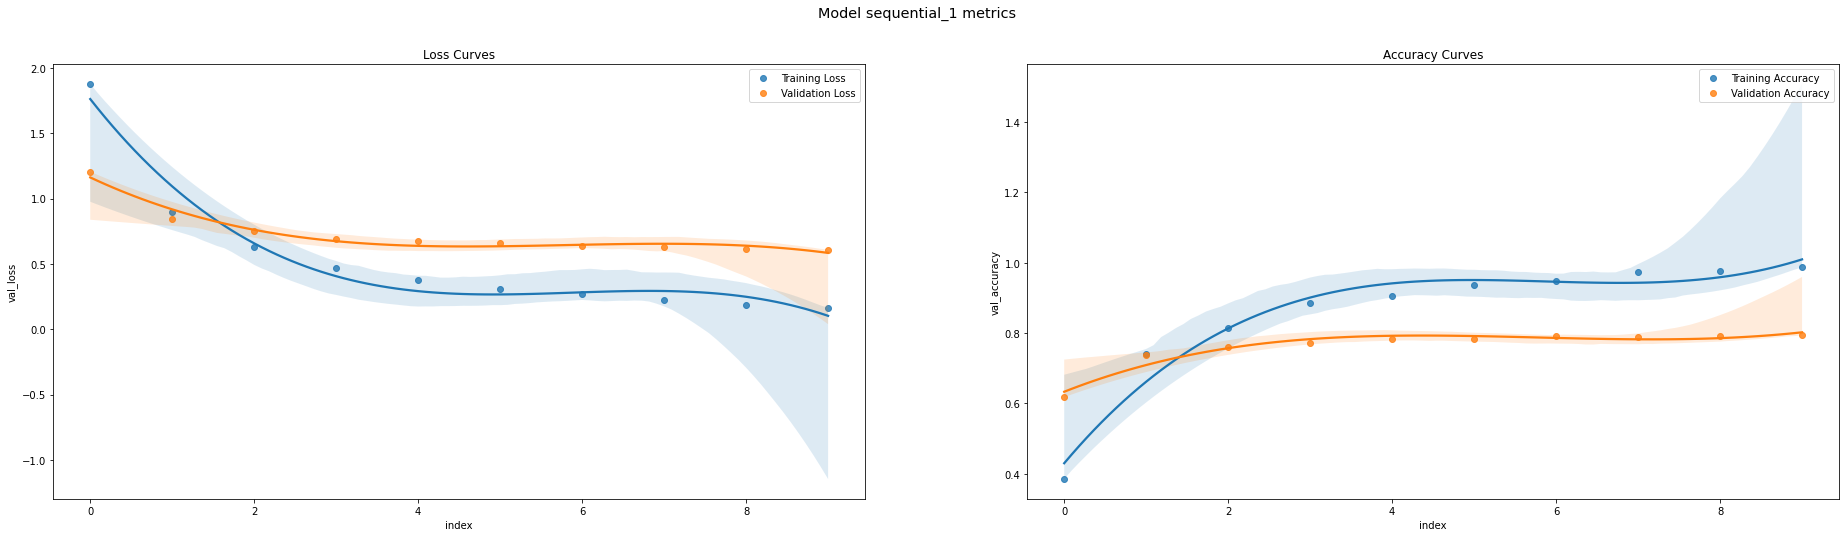

In [ ]:
plot_curves_with_regression(resnet_history, order=3)

### Create EfficientNetB0 TensorFlow Hub *Feature* Extraction Model

In [ ]:
efficientnet_model = create_model(efficientnet_url)

In [ ]:
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
efficientnet_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

In [ ]:
# Create TensorFlow Callback for the model
efficientnet_model_callback = create_tensorboard_callback('food101_transferL', 'efficentnet_001')

Saving TensorBoard log files to food101_transferL/efficentnet_001/20220717-145217


In [ ]:
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              validation_data=test_data_10_percent,
                                              epochs=10,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[efficientnet_model_callback])

Epoch 1/10
24/24 [==============================] - 26s 594ms/step - loss: 1.8406 - accuracy: 0.4267 - val_loss: 1.2981 - val_accuracy: 0.7328
Epoch 2/10
24/24 [==============================] - 13s 577ms/step - loss: 1.0538 - accuracy: 0.7733 - val_loss: 0.8657 - val_accuracy: 0.8160
Epoch 3/10
24/24 [==============================] - 13s 571ms/step - loss: 0.7516 - accuracy: 0.8307 - val_loss: 0.6993 - val_accuracy: 0.8396
Epoch 4/10
24/24 [==============================] - 13s 558ms/step - loss: 0.6021 - accuracy: 0.8587 - val_loss: 0.6122 - val_accuracy: 0.8508
Epoch 5/10
24/24 [==============================] - 13s 557ms/step - loss: 0.5083 - accuracy: 0.8867 - val_loss: 0.5614 - val_accuracy: 0.8608
Epoch 6/10
24/24 [==============================] - 13s 553ms/step - loss: 0.4418 - accuracy: 0.9133 - val_loss: 0.5247 - val_accuracy: 0.8640
Epoch 7/10
24/24 [==============================] - 13s 560ms/step - loss: 0.3874 - accuracy: 0.9253 - val_loss: 0.4972 - val_accuracy: 0.8688

/usr/local/lib/python3.7/dist-packages/seaborn/algorithms.py:85: RankWarning: Polyfit may be poorly conditioned
  boot_dist.append(f(*sample, **func_kwargs))


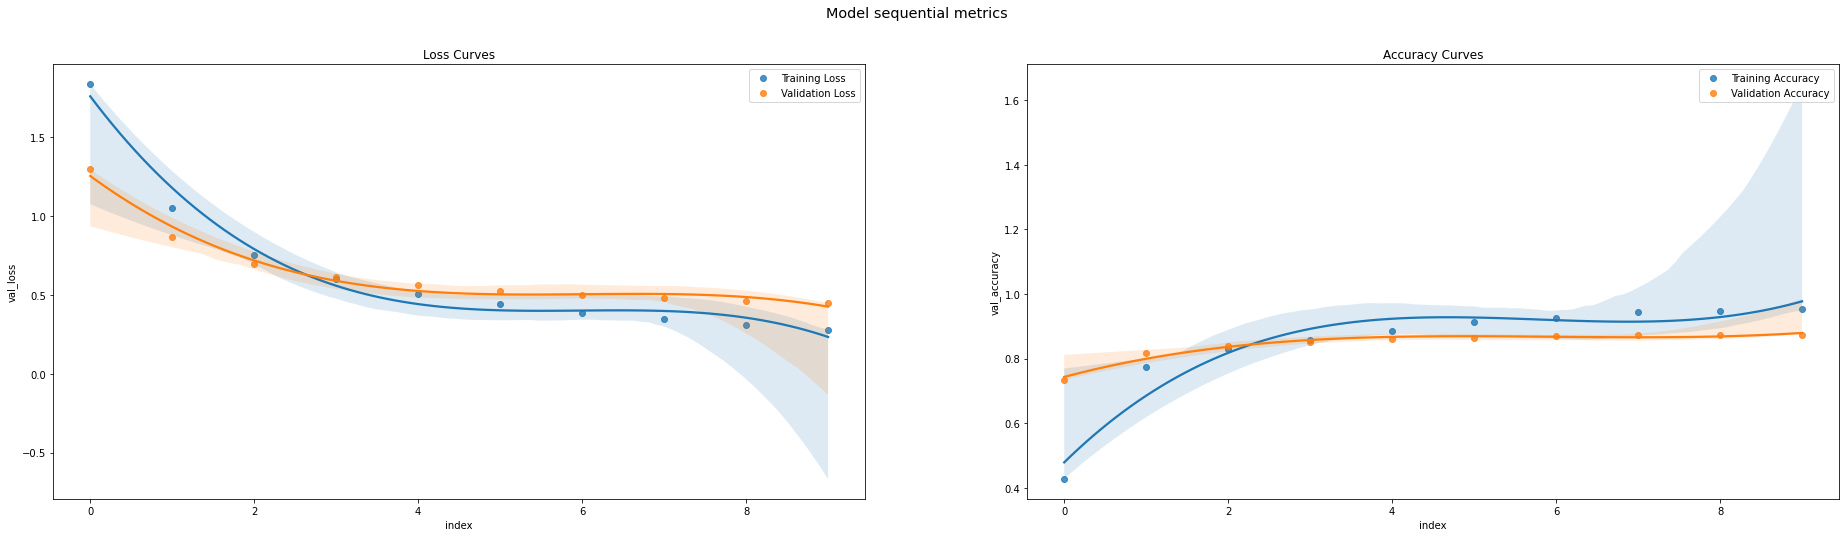

In [ ]:
plot_curves_with_regression(efficientnet_history, order=3)

#### **Types of transfer learning**
- "As is" transder learning - no changes whatsoever
- "Feature extraction" transfer learning - using the prelearned patterns and adjusting the target
- "Fine-tuning" transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers

### Compare models' results using TensorBoard

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./food101_transferL/ \
  --name "EfficientNetB0 vs ResNet50V2" \
  --description "Comparing two standard image vision models on food101 data, 10 classes" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./food101_transferL/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=Vc6udWjFsjXrFQGE47hMMa3DDB429I&prompt=consent&access_type=

The link: https://tensorboard.dev/experiment/WBa5GMkeSj2TrkP1MoaSnA/

In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/WBa5GMkeSj2TrkP1MoaSnA/
	Name                 EfficientNetB0 vs ResNet50V2
	Description          Comparing two standard image vision models on food101 data, 10 classes
	Id                   WBa5GMkeSj2TrkP1MoaSnA
	Created              2022-07-17 15:17:52 (4 minutes ago)
	Updated              2022-07-17 15:17:53 (4 minutes ago)
	Runs                 2
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  1417121
Total: 1 experiment(s)
